In [1]:
""" Helper imports"""
import re
import html.parser
import pandas as pd
import unicodedata
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
import string
from datetime import date, timedelta
from collections import Counter
from operator import itemgetter

"""Modeling imports"""
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf

""" Plotting imports"""
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

""" Google imports"""
from google.cloud import bigquery

# remove this later
pd.set_option('max_colwidth', 110)
import warnings
warnings.filterwarnings('ignore')

In [1]:
import umap
import hdbscan
from sentence_transformers import SentenceTransformer

### ---Helper functions---

In [3]:
# Contraction dictionary
data_path = '/home/jupyter/bi-topic-modeling/data/' 
# data_path = "./data/"
contraction_destination = data_path + 'contraction_dictionary.pkl'
c_dict = pd.read_pickle(contraction_destination)

# Compiling the contraction dict
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

def listToString(s):  
    str1 = " " 
    return (str1.join(s)) 

# Function to expand contractions
def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)

# Function to remove unicode
def normalize_unicode(input_str):
    # replaces accents by converting to byte literal and then decoding to utf-8.
    nfkd_form = unicodedata.normalize('NFKD', input_str) 
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode("utf-8")  

# Function to remove the html
class HTMLTextExtractor(html.parser.HTMLParser):
    def __init__(self):
        super(HTMLTextExtractor, self).__init__()
        self.result = []
    def handle_data(self, d):
        self.result.append(d)
    def get_text(self):
        return ''.join(self.result)

def html_to_text(html):
    s = HTMLTextExtractor()
    s.feed(html)
    return s.get_text()

def remove_html(text):
    text = str(text)
    string = re.sub('<[^<]+?>', ' ', text)
    string = html_to_text(string)
    string = re.sub('’', "'", string) 
    string = re.sub(r'[^\x00-\x7F]+', ' ', string) # [^\x00-\x7F]+ searches for all non-ASCII values
    string = re.sub(r'\[.*?\]', ' ', string) # escape special characters mentioned inside []
    string = string.replace('\r', '  ')
    string = string.replace('\n', '  ')
    string = re.sub(' +', ' ', string)
    return string

# Function to remove newline character
def remove_newline(string):
    string = string.replace('\r', '') #remove carriage return
    return string.replace('\n', '') #remove newline

In [4]:
# Note: not included 'Thursday' and 'Friday' because of thanksgiving and black friday related mentions
STOP_WORDS = pd.read_pickle(data_path + 'forbes_stop_words.pkl')
"names" in STOP_WORDS

True

### --- Input data ---

* Random 1000 articles during the time period: 11-Feb-2021 to 17-Feb-2021

In [5]:
df = pd.read_csv(data_path + 'raw/articles.csv')

In [6]:
df.head()

,categoryName,tier1,tier2,content_natid,pub_date,title,body,clean_body
0,Computer Software and Applications,Technology & Computing,Computing,blogandpostid/blog/post/6803-6023eb1ad61df20006dff468,2021-12-31,76% Of Smartphone Owners Use Mobile Apps To Manage Their Finances,"[id=23]<h2 class=""subhead-embed color-accent bg-base font-accent font-size text-align"">OBSERVATIONS FROM T...",76% of smartphone owners use mobile apps to manage their finances. observations from the fintech snark tan...
1,Green Vehicles,Automotive,Auto Type,blogandpostid/blog/post/1468-602c35b19335830006abbd9c,2021-02-17,Buy Churchill Capital IV (CCIV) On $12B Lucid Motors Merge Report,"[id=0]<p>A former Tesla<fbs-ticker data-name=""TSLA"" data-href=""https://www.forbes.com/companies/tesla""><a ...",buy churchill capital iv (cciv) on $12b lucid motors merge report. a former tesla tsla executive cofounded...
2,Consumer Electronics,Technology & Computing,Consumer Electronics,blogandpostid/blog/post/2978-602cdf4a937e4500069dc063,2021-02-17,Iconic British Audio Brand Unveils Its First Pair Of Active Noise-Canceling Earphones,"[id=0]<p>Recently, KEF, the iconic British speaker manufacturer, released its first-ever pair of ANC (acti...","iconic british audio brand unveils its first pair of active noise-canceling earphones. recently, kef, the ..."
3,Real Estate Buying and Selling,Real Estate,Real Estate Buying and Selling,blogandpostid/blog/post/4972-602bd2797529240006822ee2,2021-02-17,"When Hiring For Your Real Estate Business, Focus On 'Who' Rather Than 'What'","<p><em>Mike McMullen is the CEO of&nbsp;</em><a href=""https://myprominencehome.com/"" target=""_blank"" class...","when hiring for your real estate business, focus on 'who' rather than 'what'. mike mcmullen is the ceo of ..."
4,Marketing and Advertising,Business and Finance,Business,blogandpostid/blog/post/4254-602c1ff927035b000647a50b,2021-02-17,"The Good, The Bad And The Value Of Affiliate Marketing","<p><em>VP of Marketing at&nbsp;</em><a href=""http://www.clickbank.com/"" target=""_blank"" class=""color-link""...","the good, the bad and the value of affiliate marketing. vp of marketing at clickbank , overseeing all mark..."


In [7]:
sorted(df.pub_date.unique())

['2021-02-11',
 '2021-02-12',
 '2021-02-13',
 '2021-02-14',
 '2021-02-15',
 '2021-02-16',
 '2021-02-17',
 '2021-12-31']

In [8]:
print(len(df.tier1.unique()))
df.tier1.value_counts()

29


Business and Finance        245
Personal Finance            120
Sports                       89
Technology & Computing       73
Medical Health               71
News and Politics            64
Video Gaming                 34
Automotive                   30
Travel                       23
Food & Drink                 23
Style & Fashion              22
Events and Attractions       22
Real Estate                  22
Careers                      21
Education                    19
Music and Audio              18
Shopping                     18
Movies                       17
Science                      17
Television                   13
Home & Garden                 7
Family and Relationships      6
Healthy Living                5
Hobbies & Interests           4
Pop Culture                   3
Fine Art                      2
Books and Literature          2
Pets                          1
Religion & Spirituality       1
Name: tier1, dtype: int64

### --- Exploration ---

In [ ]:
# distribution of article length

<AxesSubplot:>

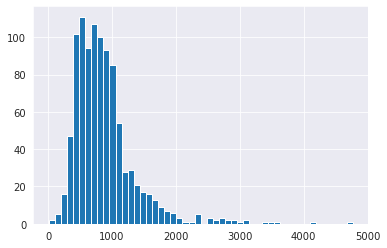

In [14]:
df["article_length"] = df.clean_body.str.split().apply(len)
df["max_sent_len"] = df.clean_body.apply(lambda elem: max([len(x.split()) for x in sent_tokenize(elem)]))
df["article_length"].hist(bins=50)

In [ ]:
# distribution of sentence length

count     992.000000
mean       58.490927
std        40.363159
min         5.000000
25%        44.000000
50%        51.000000
75%        63.000000
max      1053.000000
Name: max_sent_len, dtype: float64



<AxesSubplot:>

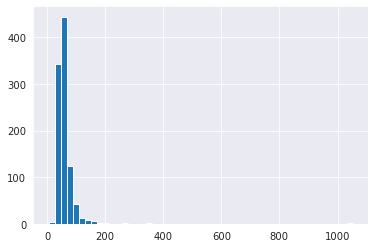

In [15]:
print(df["max_sent_len"].describe())
print()
df["max_sent_len"].hist(bins=50)

### --- Topic Modeling ---

2 ways:

| Approach 1 (NMF)     | Approach 2 (Current) |
| :-----------: | :-----------: |
| Learn joint probability of document-topics and topic-words. <br> E.g. LDA      | Get context embeddings and cluster       |
| Had to provide # of topics   | # of topics not specified        |
| Found 30 topics.  <br> 25 were coherent.   | Idea: See if - <br> 1. quality of topics improve <br> 2. granularity of topics increases        |

<br>

**Approach 2 Pipeline:** Sentence-bert embeddings -- UMAP Dimensionality Reduction -- HDBSCAN Clustering -- TF-IDF on clustered articles to form topic-words <br>

Inspiration - https://www.reddit.com/r/LanguageTechnology/comments/iyem6w/topic_modeling_or_text_clustering_what_approaches/

In [17]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 2)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

* **How to get article embeddings?**
    * Transformer models (Bert) have token limit. Everything else is truncated. So embedding might be generalization
    * To obtain article embedding:
        * Calculate each sentence's embedding
        * Avg them to get 1 embedding of length 768

[Ref](https://www.sbert.net/examples/applications/computing-embeddings/README.html#input-sequence-length)


* **Why BERT model distilbert-base-nli-mean-tokens?**
    * The [Model](https://www.sbert.net/docs/pretrained_models.html) is trained for semantic similarity plus 'distil' is faster
    * Other option: Universal Sentence Encoder via Spacy - for better performance on similarity tasks


* **Why UMAP?**  
    * Effective preprocessing step to boost the performance of density based clustering. 
    * Does a good job of learning the local structure within data 


* **Why HDBSCAN?** 
    * excels even when the data has:
        * Arbitrarily shaped clusters
        * Clusters with different sizes and densities
        * Noise
    * Cool thing: doesnt force every article into a cluster
    * Why cluster size 5?
        * Felt like a good min size and got good granular topics

[Ref 1](https://hdbscan.readthedocs.io/en/latest/parameter_selection.html) [Ref 2](https://towardsdatascience.com/understanding-hdbscan-and-density-based-clustering-121dbee1320e)

In [18]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

def algo(data):
    
    # get embeddings
    article_embeddings = []
    for article_body in data:

        embedding_sent = []
        art_sentences = sent_tokenize(article_body)
        # for each sent in article, compute embedding and append in embedding_sent list
        for sent in art_sentences:
            embedding_sent.append(model.encode(sent))

        # avg. all sent embedding to get article embed.
        art_embed = np.mean(embedding_sent, axis=0)

        article_embeddings.append(art_embed) 
    print("article_embeddings len:", len(article_embeddings))
    
    # dimensionality reduction
    umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(article_embeddings) #min_dist=0.0,
    
    # cluster
    shi = hdbscan.HDBSCAN(min_cluster_size=5,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)
    
    # plot clusters and outliers
    # prepare data  - reduce to 2D for the purpose of plotting
    umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(article_embeddings)
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = cluster.labels_

    # Visualize clusters
    fig, ax = plt.subplots(figsize=(20, 10))
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD') #, s=20 lw=10
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, cmap='hsv_r') # s=0.05, lw=10
    plt.colorbar()
    
    # put topics in dataframe
    docs_df = pd.DataFrame(data, columns=["Doc"])
    docs_df['Topic'] = cluster.labels_
    docs_df['Doc_ID'] = range(len(docs_df))
    
    # combine together all articles belonging to same cluster  
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
    
    # calculate countVector and tf-idf
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))
    
    # top n words, topic size
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
    topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)
    
    return docs_df, top_n_words, topic_sizes

In [ ]:
# grey are outliers

992
article_embeddings len: 992


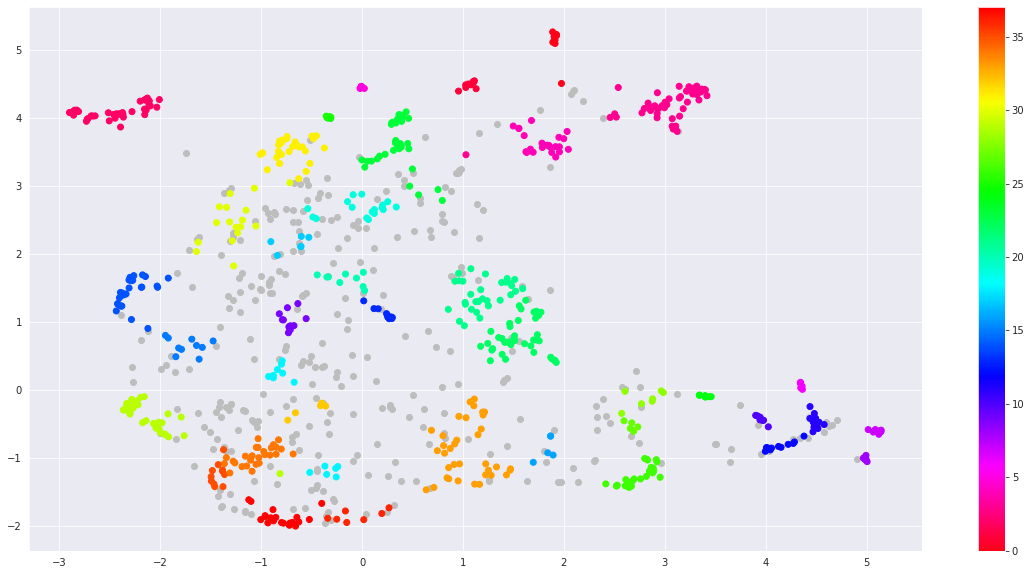

In [19]:
# SETTINGS - umap:n_neighbors=15, n_components=5, hdbscan min_cluster_size=5, input = full article

data = df.clean_body.tolist()
print(len(data))

docs_df, top_n_words, topic_sizes = algo(data) # 11.46

In [20]:
topic_sizes.sort_values('Topic')

,Topic,Size
0,-1,321
1,0,13
2,1,12
3,2,45
4,3,52
5,4,24
6,5,6
7,6,6
8,7,12
9,8,9


In [199]:
joined_df = docs_df.join(df[['tier1', 'title', 'content_natid', 'pub_date']])
# joined_df.to_csv("for_tomorrow.csv", index=False)
joined_df.head()

,Doc,Topic,Doc_ID,tier1,title,content_natid,pub_date
0,76% of smartphone owners use mobile apps to manage their finances. observations from the fintech snark tank a new study from cornerstone advisors found that 76% of all smartphone owners use mobile apps to manage their finances from fintech compan...,23,0,Technology & Computing,76% Of Smartphone Owners Use Mobile Apps To Manage Their Finances,blogandpostid/blog/post/6803-6023eb1ad61df20006dff468,2021-12-31
1,"buy churchill capital iv (cciv) on $12b lucid motors merge report. a former tesla tsla executive cofounded lucid motors in 2007. 14 years later reuters reported that lucid could go public via cciv, a special purpose acquisition company (spac), sp...",19,1,Automotive,Buy Churchill Capital IV (CCIV) On $12B Lucid Motors Merge Report,blogandpostid/blog/post/1468-602c35b19335830006abbd9c,2021-02-17
2,"iconic british audio brand unveils its first pair of active noise-canceling earphones. recently, kef, the iconic british speaker manufacturer, released its first-ever pair of anc (active noise-canceling) earphones. the new mu3 earphones were desi...",2,2,Technology & Computing,Iconic British Audio Brand Unveils Its First Pair Of Active Noise-Canceling Earphones,blogandpostid/blog/post/2978-602cdf4a937e4500069dc063,2021-02-17
3,"when hiring for your real estate business, focus on 'who' rather than 'what'. mike mcmullen is the ceo of prominence homes and the author of build. rent. sell. repeat! every business owner understands the misery of hiring the wrong person. i cert...",37,3,Real Estate,"When Hiring For Your Real Estate Business, Focus On 'Who' Rather Than 'What'",blogandpostid/blog/post/4972-602bd2797529240006822ee2,2021-02-17
4,"the good, the bad and the value of affiliate marketing. vp of marketing at clickbank , overseeing all marketing & education. in the world of digital advertising, there is not a more complex character than affiliate marketing. it has an interestin...",15,4,Business and Finance,"The Good, The Bad And The Value Of Affiliate Marketing",blogandpostid/blog/post/4254-602c1ff927035b000647a50b,2021-02-17


* Topic quality comparison with NMF:
    * some good article cluster
    * missed on some obvious word-freq based ones like apple, education related articles
    
    
* Topic granularity comparison with NFM:
    * More granular - e.g. sports, renewable energy, military

*(Quality - Good )*

**Topic 0 -** student loan  <br>
**Topic 1 -** texas <br>
**Topic 2 -** tech hardware <br>
**Topic 3 -** trump impeachment <br>
**Topic 4 -** vaccine <br>
**Topic 5 -** box office <br>
**Topic 6 -** wwe <br>
**Topic 7 -** baseball <br>
**Topic 8 -** football <br>
**Topic 10 -** tennis <br>
**Topic 12 -** basketball <br>
**Topic 13 -** astronomy <br>
**Topic 14 -** tax <br>
**Topic 15 -** small business <br>
**Topic 16 -** television <br>
**Topic 17 -** renewable energy <br>
**Topic 20 -** military <br>
**Topic 22 -** food & travel <br>
**Topic 23 -** billionaires <br>
**Topic 24 -** songs & movies <br>
**Topic 25 -** stocks <br>
**Topic 26 -** video game <br>
**Topic 27 -** movies <br>
**Topic 28 -** streaming channel movies <br>
**Topic 30 -** economy (Sports) <br>
**Topic 31 -** trading (Sports) <br>
**Topic 34 -** employees / organizations (Sports) <br>
**Topic 37 -** employee skills <br>
<br>
*(Quality - Bad )*:<br>
**Topic 9 -** health  <br>
**Topic 11 -** sports <br>
**Topic 18 -** post covid? <br>
**Topic 19 -** automotive? <br>
**Topic 21 -** business? <br>
**Topic 29 -** self driving + tech <br>
**Topic 32 -** transformation <br>
**Topic 33 -** music, style <br>
**Topic 35 -** influencer/small/medium business? <br>
**Topic 36 -** bicycle <br>

In [22]:
# modify top_n_words dict into dataframe for presentation
topic_words_dict = {}  

for k, v in top_n_words.items():
    topic_words_dict[k] = ", ".join([elem[0] for elem in v])

pd.set_option("max_colwidth", 250)
topic_words_df = pd.DataFrame.from_dict(topic_words_dict, orient='index').reset_index().rename(columns={'index':'topic_num', 0:'top_20_words'}) 
topic_words_df

,topic_num,top_20_words
0,-1,"businesses, students, university, bitcoin, school, financial, energy, research, climate, startup, glenda, global, economic, technology, small, community, mascara, family, education, job"
1,0,"student loan, loan, student loans, loans, student, borrowers, forgiveness, loan forgiveness, cancellation, debt, loan cancellation, cancel, loan debt, 000 student, cancel student, biden, student debt, federal student, congress, repayment"
2,1,"texas, outages, storm, carbon monoxide, monoxide, weather, power, cold, monoxide poisoning, houston, power outages, poisoning, winter storm, blackouts, wind, temperatures, winter, ercot, tuesday, carbon"
3,2,"apple, batteries, s21, samsung, galaxy, battery, aa, inch, ultra, iphone, tv, laptop, android, s21 ultra, wireless, apples, rear, galaxy s21, features, aa batteries"
4,3,"trump, vote, sen, republicans, capitol, impeachment, gop, republican, senate, voted, convict, trial, donald, democrats, senators, trumps, romney, president, donald trump, saturday"
5,4,"vaccine, doses, novavax, pfizer, vaccines, cruise, moderna, astrazeneca, 19 vaccine, million doses, trials, shot, vaccination, coronavirus, vaccinated, cases, biontech, countries, dose, ambulance"
6,5,"detective chinatown, chinatown, detective, china, earned, cume, million domestic, domestic, weekend, opening weekend, avengers, endgame, avengers endgame, f9, box office, million china, imax, movie, debut, million day"
7,6,"wwe, nxt, wrestling, evans, elimination chamber, elimination, match, chamber, raw, wwes, def, smackdown, wwe raw, wwe nxt, miz, pro wrestling, million january, views, viewership, nia"
8,7,"arenado, cubs, yankees, pitchers, mets, home runs, darling, pitching, indians, bauer, runs, cutter, arrieta, spring training, contract, rockies, pitcher, league, ball, herrera"
9,8,"packers, quarterback, yards, giants, 49ers, vikings, green bay, cousins, nfl, bay, pass, defensive, offensive, san francisco, bears, francisco, san, quarterbacks, robinson, seasons"


**Discussion for data product:**<br>

In our use-case, no article should be left unassigned to a topic, correct?

* Solution:
    * Apply NMF on unassigned 300 articles. 
        * Things get complicated when NMF assigns say basketball as topics to some, already present above. Then a step to merge the articles would need implemented
        <br> <br>
    * Change clustering algo to k-Means (non-Density based)
        * Did this but had not reduced dimensions using UMAP - maybe thats why gave bad results
        * Will need to provide # of topics automatically

**WIP:** 
    
* Topic engagement -
    * For a given topic (say texas):
        * fetch avg. time on page for each article under the topic
        * avg. it out to get topic-level engagement
        
* Topic popularity -
    * For a given topic (say texas):
        * sum gsc queries for each article
        * avg. it out to get topic-level popularity

**LATEST LAST 1 or 2 DAYS**

In [171]:
# lets just take 3rd Apr for now
latest_df.date.value_counts()

2021-03-31    496
2021-03-30    427
2021-04-01    393
2021-04-05    316
2021-04-02    237
2021-04-03     94
2021-04-04     81
2021-03-29     12
Name: date, dtype: int64

In [173]:
# testing articles published on a latest date - Apr 3rd 

(94, 10)

94
article_embeddings len: 94


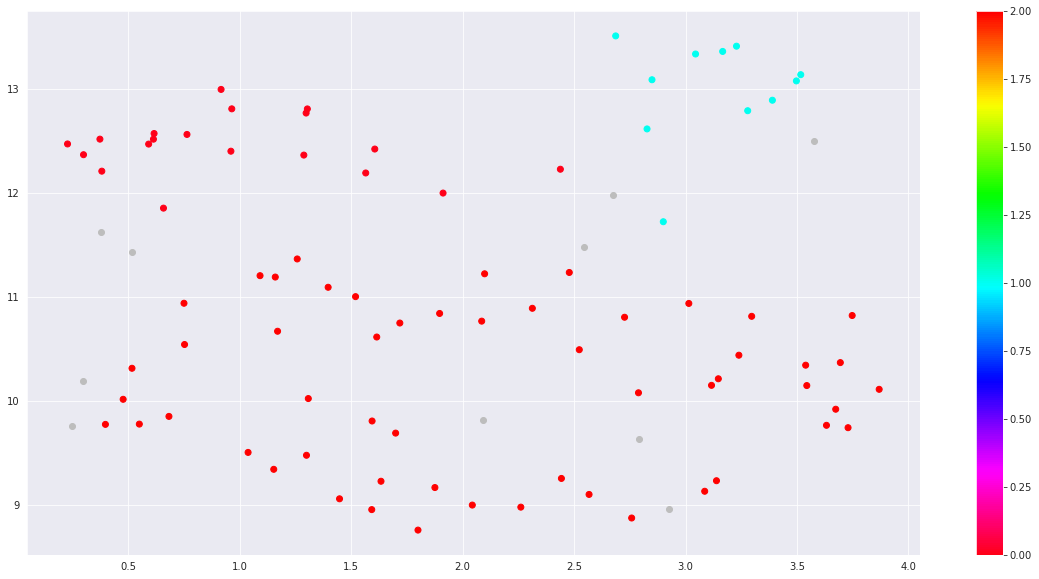

In [177]:
# SETTINGS - umap:n_neighbors=15, n_components=5, hdbscan min_cluster_size=5, input = full article

latest_data = latest_df.clean_body.tolist()
print(len(latest_data))

latest_docs_df, latest_top_n_words, latest_topic_sizes = algo(latest_data) # 4mins 

In [178]:
latest_topic_sizes.sort_values('Topic')

,Topic,Size
0,-1,10
1,0,19
2,1,11
3,2,54


**Verdict:** Bad topics and bad clustering

In [181]:
# modify top_n_words dict into dataframe for presentation
latest_topic_words_dict = {}  

for k, v in latest_top_n_words.items():
    latest_topic_words_dict[k] = ", ".join([elem[0] for elem in v])

pd.set_option("max_colwidth", 250)
latest_topic_words_df = pd.DataFrame.from_dict(latest_topic_words_dict, orient='index').reset_index().rename(columns={'index':'topic_num', 0:'top_20_words'}) 
latest_topic_words_df

,topic_num,top_20_words
0,-1,"fees, totality, eclipse, hip hop, hop, hip, youn, affiliate, agents, game pass, patent, agents fees, affiliate marketing, device, pass, actress, marketing, 2024, path, transfer"
1,0,"garoppolo, gonzaga, kentucky derby, charts, baylor, ucla, marshall, stakes, movie, warriors, blue grass, kentucky, movies, races, quarterback, grass, santa, race, santa anita, trade"
2,1,"ds, ios, ev6, ios 14, laptop, starlink, battery, iphone, inch, range, kia, macbook, tesla, apple, x1, display, model, battery life, nano, design"
3,2,"capital, companies, driving cars, student loan, dividend, demolition, banks, sunscreen, ai, trump, human, lewis, management, election, jumio, dunhams, department, key, cancellation, retail"


**Compare NMF on 1 day**

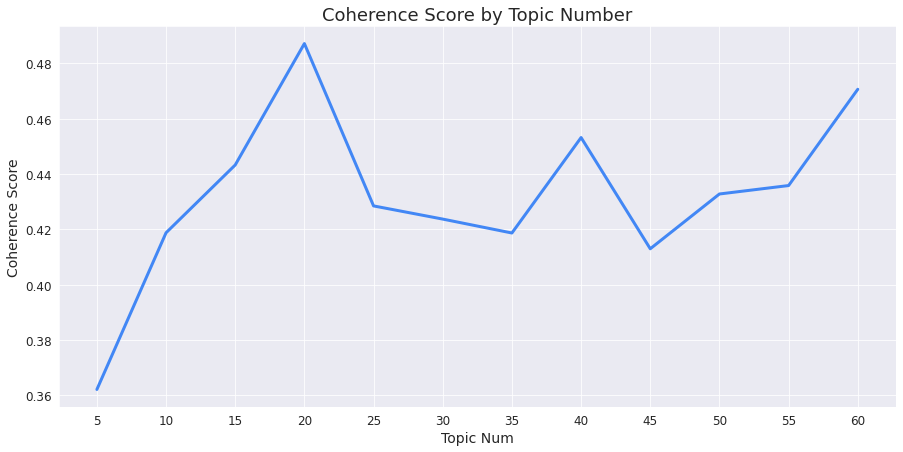

In [182]:
texts = latest_df['processed_noun']

dictionary = Dictionary(texts)
# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=3, no_above=0.85, keep_n=5000)
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers to try
topic_nums = list(np.arange(5, 60 + 1, 5))

coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot( topic_nums, coherence_scores, linewidth=3, color='#4287f5')

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
# plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.title('Coherence Score by Topic Number', fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)
plt.show() #3mins

**Verdict:**

Overall bad topics. Only few are good ones

In [184]:
def topic_table(n_top_words, feature_names, model):
    topics = {}
    for i, topic_vec in enumerate(model.components_):
        topic_descr = ''
        for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
            topic_descr = topic_descr + feature_names[fid] + " "
        topics[i] = topic_descr
    return pd.DataFrame({'Top_Topic_Terms': topics})

docweights = nmf.transform(tfidf_vectorizer.transform(texts))
# using top 2 words to name the topic
n_top_words = 20

topic_df = topic_table(
    n_top_words, 
    tfidf_feature_names, nmf).T

topic_df = topic_df.T.reset_index()
topic_df

,index,Top_Topic_Terms
0,0,retirement tax bill plan house market markets year relief city money infrastructure dollars student package taxes president spending years loan
1,1,apple iphone apples watch leak release privacy mini feature capability move facebook phone app power step display year information sources
2,2,game playstation pass players xbox games level franchise outriders championship team houston show things design title end mlb stadium odds
3,3,film movie godzilla weekend trailer space theaters widow conversations james actress movies summer films bros flick king release kong likes
4,4,points charts rankings week movies place position netflix days georgia houston list programs odds show additions day march championship run
5,5,decision baseball braves game mlb atlanta media voting law league commissioner voter rob commissioner rob afternoon georgia voting law league baseball park fraud
6,6,car cars model battery range performance design miles power display drivers looks levels life bit models weight test minutes derby
7,7,capital round company companies market investment investors deal dividends firm business estate growth firms quarter income services law assets date
8,8,season pick show seasons draft scenes trailer quarterback league players something mvp trade bay summer stars team characters hes coach
9,9,derby stakes race races santa quality et horse cars run favorite reports bettors winner coverage saturday roses wagers spirit road


* Articles across 1 or 2 days, might not have coherent topics, unless there is a breaking news happening

Solution:
* For purpose of generating topics and their words, club 7 days of articles together and run it

* For purpose of saving in BQ, only save 1 day's articles which were not already saved 

## 4/6/21 Demo:

**Discussed:**
1. Rob approved of results and method so far. Said - What is more important for us - is getting good topics.
2. For data product - options are:
    * choose all articles that had over 100 PVS in 1 day (or check for 7 days)
    * or unique articles published in past 7 days
3. check feasibility of a model trained once and able to predict (like train every 7 days). If not - we can train everyday
4. Topic descriptions - are going to be bunch of words. We will not get into topic naming (business will also come with non-feasible expectations). We agree on topic descriptions being some words or a short summary (difficult but do check)  
5. We are fine with exploring a 2 step process - HDBSCAN + NMF. 
    * Very future enhancement - train our own Doc2Vec for all articles. Doc2Vec neural network approach, very little time is spent on pre-cleaning the data with stemmers, tokenizers, etc.
**TODO:**

#### GOOD QUALITY TOPICS

1. Filter out articles with very small length - thats garbage -- DONE 
2. Develop metrics to measure cluster goodness - -- DONE
    * count of IAB tiers in one topic
    * calculate density score. If Silhouette isnt right for DBSCAN, find other right ones to compare 
    * calculate cosine similarity of articles in a topic
    * calculate variance of?
3. Look at NYT, WSJ, Conde Nast - to see wha they are doing for topic modeling -- DONE 
    * NYT, Conde Nast use LDA. But their articles dint mention any specifics of implementation
    * WSJ use [UMAP+HDBSCAN](https://medium.com/the-wall-street-journal/staying-on-topic-building-an-automated-topic-model-of-wsj-news-coverage-d4dc4369f71b)
4. Check if hdbscan can predict topics on incoming articles -- DONE

5. Clean topic-words -- DONE
6. [POC] Apply modeling on individual IAB category level -- DONE
    * See if multiple topics for varying hierarchy possible - i.e. inspect and compare topic labels on both levels
    * Conclusion - not helpful at IAB level. Would have over-complicated issues. Instead cluster all but keep cluster size small

#### DATA PRODUCT
1. Improve code run-time -- DONE

2. [POC] Train clusterer and predict article topics -- WIP
    * Decide number of days to train/predict and frequency of running VM  -- WIP
    * Decide input for training - unique articles published or articles read? -- Decided to keep using articles read
    
3. check if a topic can be described by a summary of short length. summary taken from all articles combined together -- DONE 
4. [POC] Finalize pipeline: 2 step HDBSCAN+NFM? -- Not going to do. Maybe in 2.0 enhancement if required.

### Question 6/3/2021:

* What is the intent of predicting topics?
    - Is it to show say pvs last week for a topic vs this week?
    - How far out such comparisons need to be made? -- that will decide the date range of training and prediction -- a week isgood strat
    
    
* Should the topic-words be recomputed based on predicted cluster? --Show excel example--keep sanme, but small numbers

* Example of some use-cases? -- that will decide if every article should get a topic i.e. should I try out ensembling HDBSCAN + NMF?

In [ ]:
# good one - https://github.com/codelucas/newspaper --takes a url and then returns information about the article, including the authors and full text

**Good text about topic modeling**
* A topic model has the ability to automatically learn topics we write about that no one ever thought to label (i.e. tags attached to articles by authors) — and can be helpful to help us summarize each article into one label that describes “what’s it all about.” 
* Use these topic labels as an analytics tool to group content together and answer content performance questions (e.g. Which topics are most engaging on weekdays vs. weekends?). 
* Grouping articles by machine-generated topics instead of hand-labeled ones might reveal insights we wouldn’t have otherwise found.

**WSJ's topic modeling**
* Features of a good topic model 
    * It should be dynamic, meaning it should be able to gracefully accept new articles each day as new articles are published. 
    * It should be hierarchical, implying that for a specific piece of content, we could assign multiple topics at multiple levels of granularity, like “Politics” (coarse-grained) or “Trump-China Tax Policy” (fine-grained). 
    * An ideal model would also be able to generate human-interpretable labels, and of course it must be precise
*  Example of insight after TM:
    * While each section publishes approximately the same number of articles each week, topic-wise publication volume may ebb and flow over time, creating an improved lens into what we cover, and for whom.
    * use topic labels as features for content strategy or in other data science models.
* Hierarchy topic labels example: Level 0 (15 topics) labels-0, Level 1 (50 Topics) labels-1, Level 2 (100 Topics) labels-3
* In HDBSCAN, every article receives a probability score describing how “close” each article is to belonging in one of the N topics.

In [ ]:
# add predicted topic to dataset
nyt$pred_topic <- topics
nyt$year <- substr(nyt$datetime, 1, 4) # extract year
 # frequency table with articles about stock market, per year
tab <- table(nyt$year[nyt$pred_topic==2])
plot(tab)

In [ ]:
# Universal Sentence Embeddings -  It is one of the few models that is designed to handle longer-than-sentence-length inputs, making it handy for encoding our articles.
# Ensemble models out-performed our linear model, leading us to believe that careful modeling of interactions and nonlinear effects could improve accuracy further.
# Each article is associated with a 300-dimensional vector representing the topics this article covers, and if an article is not about a topic, then the portion would be 0. This served as our "Topics Feature Data" module.
# The Silhouette Coefficient for a set of samples is given as the mean of the Silhouette Coefficient for each sample. The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
# https://github.com/scikit-learn-contrib/hdbscan/issues/283 -- dbcv -- quote this: https://stats.stackexchange.com/questions/359893/what-is-a-good-clustering-fitness-metric-for-dbscan

# dbcv - DBCV which can validate clustering assignments on non-globular, arbitrarily shaped clusters (such as the example above). In essence, DBCV computes two values:
# The density within a cluster
# The density between clusters
# High density within a cluster, and low density between clusters indicates good clustering assignments.

Relative validity measures deemed as “traditional”
take into account distances to quantify cluster variance
which, combined with their separation, then amounts
for clustering quality. Minimizing cluster variance and
separation, however, is not the objective in densitybased clustering. Therefore, a relative measure for
evaluation of density-based clustering should be defined
by means of densities rather than by distances.